In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

import math


Using TensorFlow backend.


In [2]:
prices_df = pd.read_csv("prices-split-adjusted.csv")

In [3]:
prices_df.head()

date symbol        open       close         low        high  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

In [7]:
prices_df['symbol'].value_counts()

MCD      1762
BWA      1762
MKC      1762
WMB      1762
PWR      1762
TXN      1762
HPQ      1762
CMI      1762
BBY      1762
PGR      1762
AMAT     1762
WHR      1762
SLB      1762
TWX      1762
CELG     1762
AMZN     1762
LEN      1762
K        1762
HCN      1762
ORLY     1762
BBT      1762
DFS      1762
INTC     1762
MU       1762
DISCA    1762
NRG      1762
NDAQ     1762
HES      1762
HOLX     1762
INTU     1762
         ... 
MPC      1008
TRIP     1008
ABBV     1008
KORS     1008
FBHS     1008
DLPH     1008
TDG      1008
KMI      1008
NLSN     1008
PSX      1008
FB       1008
HCA      1008
ZTS       987
COTY      896
MNK       894
NWS       892
NWSA      892
EVHC      853
ALLE      786
CFG       504
QRVO      504
SYF       504
NAVI      504
WRK       385
KHC       378
PYPL      378
HPE       304
CSRA      284
WLTW      251
FTV       126
Name: symbol, Length: 501, dtype: int64

In [10]:
# filter out only data of Apple
apple = prices_df[prices_df['symbol']=='AAPL']

In [11]:
apple.head()

date symbol       open      close        low       high  \
254   2010-01-04   AAPL  30.490000  30.572857  30.340000  30.642857   
721   2010-01-05   AAPL  30.657143  30.625713  30.464285  30.798571   
1189  2010-01-06   AAPL  30.625713  30.138571  30.107143  30.747143   
1657  2010-01-07   AAPL  30.250000  30.082857  29.864286  30.285715   
2125  2010-01-08   AAPL  30.042856  30.282858  29.865715  30.285715   

           volume  
254   123432400.0  
721   150476200.0  
1189  138040000.0  
1657  119282800.0  
2125  111902700.0

In [18]:
# save Apple's stock values as type of floating point number
apple_prices = apple['close'].values.astype('float32')

In [22]:
apple_prices.shape

(1762,)

In [24]:
# reshape to column vector
apple_prices = apple_prices.reshape(len(apple_prices),1)

In [25]:
apple_prices.shape

(1762, 1)

In [26]:
apple_prices

array([[ 30.572857],
       [ 30.625713],
       [ 30.13857 ],
       ...,
       [116.76    ],
       [116.73    ],
       [115.82    ]], dtype=float32)

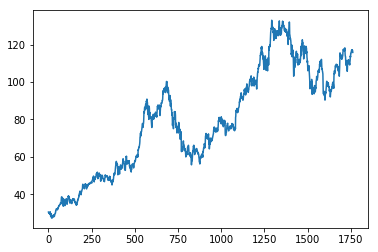

In [28]:
plt.plot(apple_prices)

In [33]:
#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
apple_prices = scaler.fit_transform(apple_prices)

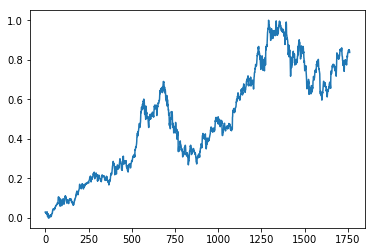

In [34]:
plt.plot(apple_prices)

In [36]:
train, test = train_test_split(apple_prices, test_size = 0.33, shuffle = False)

In [39]:
print(len(train), len(test))

1180 582


In [59]:
# convert an array of values into a time series dataset 
# in form 
#                     X                     Y
# t-look_back+1, t-look_back+2, ..., t     t+1

def create_dataset(df, look_back):
    
    dfX, label = [], []
    for i in range(len(df) - look_back-1):
        a = df[i: (i+look_back), 0]
        dfX.append(a)
        label.append(df[i + look_back, 0])
    return np.array(dfX), np.array(label)


In [60]:
# convert Apple's stock price data into time series dataset
trainX, trainY = create_dataset(train, 7)
testX, testY = create_dataset(test, 7)

In [69]:
# Train example 
#First_row :  t0  t1  t2 t3 t4 t5 t6 t7      label = t8
#Second_row:  t1  t2  t3 t4 t5 t6 t7 t8      label = t9
#Third_row:   t2  t3  t4 t5 t6 t7 t8 t9      label = t10

In [71]:
trainX.shape

(1172, 7)

In [78]:
# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1) )

In [74]:
trainX.shape

(1172, 7, 1)

In [79]:
testX.shape

(574, 7, 1)

In [106]:
#define EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(7, 1), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=32) #callbacks=[early_stop]

Epoch 1/100
1172/1172 [==============================] - 1s 817us/step - loss: 0.0036
Epoch 2/100
1172/1172 [==============================] - 0s 151us/step - loss: 3.8740e-04
Epoch 3/100
1172/1172 [==============================] - 0s 153us/step - loss: 2.8476e-04
Epoch 4/100
1172/1172 [==============================] - 0s 149us/step - loss: 2.5307e-04
Epoch 5/100
1172/1172 [==============================] - 0s 148us/step - loss: 2.4052e-04
Epoch 6/100
1172/1172 [==============================] - 0s 151us/step - loss: 2.3430e-04
Epoch 7/100
1172/1172 [==============================] - 0s 152us/step - loss: 2.3062e-04
Epoch 8/100
1172/1172 [==============================] - 0s 154us/step - loss: 2.2855e-04
Epoch 9/100
1172/1172 [==============================] - 0s 174us/step - loss: 2.2771e-04 0s - loss: 2.1907e-
Epoch 10/100
1172/1172 [==============================] - 0s 155us/step - loss: 2.2397e-04
Epoch 11/100
1172/1172 [==============================] - 0s 141us/step - loss: 2.2

keras.evaluate() is for evaluating your trained model. Its output is accuracy or loss, not prediction to your input data.

keras.predict() actually predicts, and its output is target value, predicted from your input data.


In [ ]:
#make predicitons 
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [107]:
#calculate r2 score

print("The R2 score on the Train set is= \t{:0.3f}".format(r2_score(trainY, trainPredict)))
print("The R2 score on the Test set is= \t{:0.3f}".format(r2_score(testY, testPredict)))


The R2 score on the Train set is= 	0.995
The R2 score on the Test set is= 	0.850
574/574 [==============================] - 1s 1ms/step
LSTM: 0.001493


In [128]:
#calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))

In [129]:
print('Train Score: {:2f}'.format(trainScore))
print('Test Score: {:2f}'.format(testScore))

Train Score: 0.012481
Test Score: 0.038635


In [130]:
#Evaluate the model
lstm_test_loss = model.evaluate(testX, testY, batch_size=1)
print('LSTM: %f'%lstm_test_loss)

574/574 [==============================] - 1s 1ms/step
LSTM: 0.001493


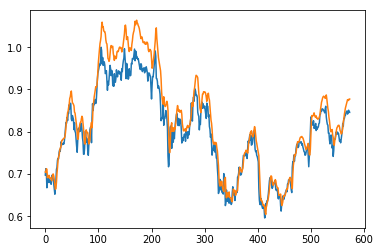

In [135]:
plt.plot(testY)
plt.plot(testPredict)